## Will Millennials Ever Get Married?

This notebook contains analysis related to a paper on marriage patterns in the U.S., based on data from the National Survey of Family Growth (NSFG).

It is based on Chapter 13 of Think Stats, 2nd Edition, by Allen Downey, available from [thinkstats2.com](http://thinkstats2.com)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import math

import matplotlib.pyplot as plt
from matplotlib import pylab

from scipy.interpolate import interp1d
from scipy.misc import derivative

import thinkstats2
import thinkplot
from thinkstats2 import Cdf

import survival
import marriage

In [2]:
%time df = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
df.shape

CPU times: user 186 ms, sys: 39.2 ms, total: 226 ms
Wall time: 232 ms


(70183, 42)

Make a table showing the number of respondents in each cycle:

In [3]:
df.cycle.value_counts().sort_index()

3      7969
4      8450
5     10847
6      7643
7     12279
8      5601
9      5699
10     5554
11     6141
Name: cycle, dtype: int64

In [4]:
SAVE_PRED = False

if SAVE_PRED:
    df = df[df['cycle'] < 10]

In [5]:
df.cycle.value_counts().sort_index()

3      7969
4      8450
5     10847
6      7643
7     12279
8      5601
9      5699
10     5554
11     6141
Name: cycle, dtype: int64

In [58]:
70183 - 5554 - 6141

58488

In [6]:
def format_date_range(array):
    a, b = array.astype(int)
    return '%d--%d' % (a, b)

def SummarizeCycle(cycle, df):
    ages = df.age.min(), df.age.max()
    ages= np.array(ages)
    
    intvws = df.cmintvw.min(), df.cmintvw.max()
    intvws = np.array(intvws) / 12 + 1900
    
    births = df.cmbirth.min(), df.cmbirth.max()
    births = np.array(births) / 12 + 1900
    
    intvw_dates = format_date_range(intvws)
    birth_dates = format_date_range(births)
    
    print(cycle, ' & ', intvw_dates, '&', len(df), '&', birth_dates, r'\\')

In [7]:
for cycle, group in df.groupby('cycle'):
    SummarizeCycle(cycle, group)

3  &  1982--1983 & 7969 & 1937--1968 \\
4  &  1988--1988 & 8450 & 1943--1973 \\
5  &  1995--1995 & 10847 & 1950--1980 \\
6  &  2002--2003 & 7643 & 1957--1988 \\
7  &  2006--2010 & 12279 & 1961--1995 \\
8  &  2011--2013 & 5601 & 1966--1998 \\
9  &  2013--2015 & 5699 & 1968--2000 \\
10  &  2015--2017 & 5554 & 1966--2002 \\
11  &  2017--2019 & 6141 & 1968--2004 \\


Check for missing values in `agemarry`:

In [8]:
def CheckAgeVars(df):
    print(sum(df[df.evrmarry].agemarry.isnull()))
    
for cycle, group in df.groupby('cycle'):
    CheckAgeVars(group)

0
22
0
37
16
17
11
0
0


Generate a table with the number of respondents in each cohort:

In [9]:
marriage.DigitizeResp(df)
grouped = df.groupby('birth_index')
for name, group in iter(grouped):
    age_range = '%d--%d' % (int(group.age.min()), int(group.age_index.max()))
    print(name, '&', len(group), '&', age_range,
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

30 & 325 & 42--45 & 310 & 0 \\
40 & 3608 & 32--45 & 3287 & 9 \\
50 & 10631 & 22--45 & 8667 & 18 \\
60 & 15064 & 15--50 & 8902 & 33 \\
70 & 16466 & 14--49 & 9185 & 30 \\
80 & 14318 & 14--39 & 5331 & 13 \\
90 & 8539 & 15--29 & 915 & 0 \\
100 & 1232 & 15--19 & 2 & 0 \\


In [10]:
def ComputeCutoffs(df):
    grouped = df.groupby('birth_index')
    cutoffs = {}
    for name, group in sorted(grouped):
        cutoffs[name] = int(group.age.max())
    return cutoffs

In [11]:
cutoffs = ComputeCutoffs(df)
cutoffs

{30: 45, 40: 45, 50: 45, 60: 50, 70: 49, 80: 39, 90: 29, 100: 19}

Estimate the hazard function for the 80s cohort (curious to see what's going on during the "marriage strike")

In [12]:
cohort = grouped.get_group(80)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

10	14305	1	0	7e-05
11	14304	1	0	7e-05
12	14303	2	0	0.00014
13	14301	12	0	0.00084
14	14289	16	14	0.0011
15	14259	60	260	0.0042
16	13939	131	242	0.0094
17	13566	183	338	0.013
18	13045	412	460	0.032
19	12173	514	569	0.042
20	11090	511	579	0.046
21	10000	505	572	0.051
22	8923	556	572	0.062
23	7795	491	454	0.063
24	6850	450	533	0.066
25	5867	398	576	0.068
26	4893	307	554	0.063
27	4032	243	506	0.06
28	3283	185	435	0.056
29	2663	122	461	0.046
30	2080	84	401	0.04
31	1595	67	360	0.042
32	1168	31	297	0.027
33	840	18	228	0.021
34	594	9	176	0.015
35	409	4	143	0.0098
36	262	2	120	0.0076
37	140	2	74	0.014
38	64	1	49	0.016
39	14	0	14	0


Run the same analysis for the 70s cohort (to extract $\lambda(33)$).

In [13]:
cohort = grouped.get_group(70)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

10	16436	2	0	0.00012
11	16434	1	0	6.1e-05
12	16433	8	0	0.00049
13	16425	13	0	0.00079
14	16412	46	3	0.0028
15	16363	101	388	0.0062
16	15874	222	518	0.014
17	15134	323	540	0.021
18	14271	636	340	0.045
19	13295	708	268	0.053
20	12319	706	242	0.057
21	11371	755	220	0.066
22	10396	761	264	0.073
23	9371	735	347	0.078
24	8289	675	345	0.081
25	7269	595	205	0.082
26	6469	534	149	0.083
27	5786	415	164	0.072
28	5207	419	198	0.08
29	4590	348	215	0.076
30	4027	278	315	0.069
31	3434	202	278	0.059
32	2954	175	212	0.059
33	2567	114	155	0.044
34	2298	103	173	0.045
35	2022	79	216	0.039
36	1727	52	203	0.03
37	1472	41	186	0.028
38	1245	27	179	0.022
39	1039	22	161	0.021
40	856	17	148	0.02
41	691	15	141	0.022
42	535	9	122	0.017
43	404	6	114	0.015
44	284	7	87	0.025
45	190	3	56	0.016
46	131	1	47	0.0076
47	83	1	51	0.012
48	31	0	24	0
49	7	0	7	0


Use the 30s cohort to demonstrate the simple way to do survival analysis, by computing the survival function directly.

[ 9.93846154e-01  9.69230769e-01  9.47692308e-01  9.01538462e-01
  8.18461538e-01  6.86153846e-01  5.60000000e-01  4.64615385e-01
  3.63076923e-01  2.95384615e-01  2.61538462e-01  2.33846154e-01
  2.12307692e-01  1.75384615e-01  1.47692308e-01  1.32307692e-01
  1.10769231e-01  1.01538462e-01  8.92307692e-02  7.69230769e-02
  7.38461538e-02  6.46153846e-02  6.15384615e-02  5.84615385e-02
  5.53846154e-02  4.92307692e-02  4.61538462e-02 -2.22044605e-16]


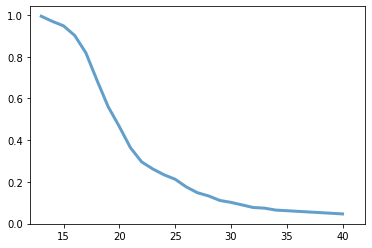

In [14]:
cohort = grouped.get_group(30)
sf = survival.MakeSurvivalFromSeq(cohort.agemarry_index.fillna(np.inf))
ts, ss = sf.Render()
print(ss)
thinkplot.Plot(ts, ss)
thinkplot.Config(xlim=[12, 42])

Then use the SurvivalFunction to compute the HazardFunction:

[0.00615385 0.0247678  0.02222222 0.0487013  0.09215017 0.16165414
 0.1838565  0.17032967 0.21854305 0.18644068 0.11458333 0.10588235
 0.09210526 0.17391304 0.15789474 0.10416667 0.1627907  0.08333333
 0.12121212 0.13793103 0.04       0.125      0.04761905 0.05
 0.05263158 0.11111111 0.0625     1.        ]


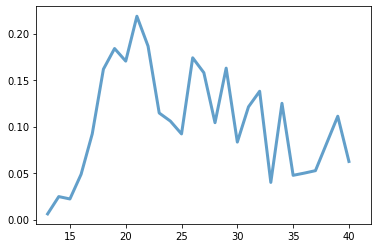

In [15]:
hf = sf.MakeHazardFunction()
ts, lams = hf.Render()
print(lams)
thinkplot.Plot(ts, lams)
thinkplot.Config(xlim=[12, 42])

Make the first figure, showing sf and hf for the 30s cohort:

In [16]:
options = dict(formats=['pdf', 'png'], clf=False)

Writing figs/marriage1.pdf
Writing figs/marriage1.png


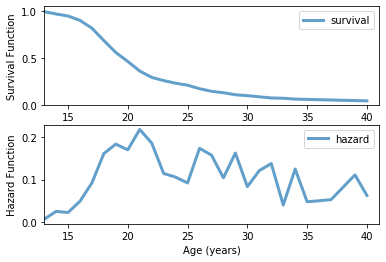

In [17]:
thinkplot.PrePlot(rows=2)

thinkplot.Plot(sf, label='survival')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
plt.ylabel('Survival Function')

thinkplot.SubPlot(2)
thinkplot.Plot(hf, label='hazard')
thinkplot.Config(xlabel='age(years)', ylabel='Hazard function', xlim=[13, 41])
plt.ylabel('Hazard Function')
plt.xlabel('Age (years)')

thinkplot.Save(root='figs/marriage1', **options)

Writing figs/marriage2.pdf
Writing figs/marriage2.png


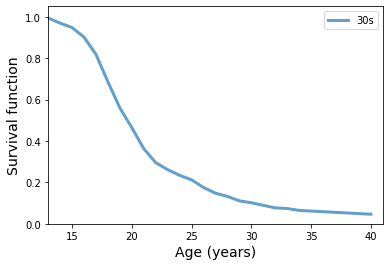

In [18]:
thinkplot.Plot(sf, label='30s')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Survival function', fontsize=14)

thinkplot.Save(root='figs/marriage2', **options)

Writing figs/marriage3.pdf
Writing figs/marriage3.png


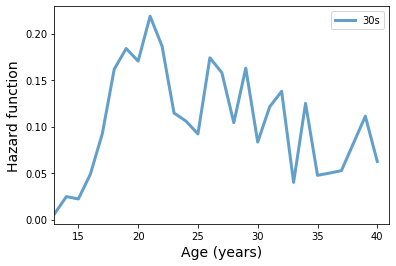

In [19]:
thinkplot.Plot(hf, label='30s')
thinkplot.Config(xlim=[13, 41])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Hazard function', fontsize=14)

thinkplot.Save(root='figs/marriage3', **options)

Make some pivot tables, just to see where the data are:

In [20]:
pt = df.pivot_table(index='birth_index', columns='age_index', values='age', aggfunc=len, fill_value=0)
pt

age_index,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,...,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,0,0,0,0,0,0,0,...,0,19,146,148,12,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,414,384,194,198,25,0,0,0,0,0
50,0,0,0,0,0,0,0,0,42,301,...,371,482,633,533,38,0,0,0,0,0
60,0,269,300,370,665,722,609,513,520,242,...,562,537,512,517,33,18,83,173,228,4
70,3,389,523,549,362,293,283,285,365,572,...,581,491,483,383,258,272,202,122,48,0
80,14,260,242,340,483,589,658,683,705,602,...,0,0,0,0,0,0,0,0,0,0
90,0,749,829,895,909,873,583,652,635,566,...,0,0,0,0,0,0,0,0,0,0
100,0,347,368,286,171,60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The following pivot table is not as helpful as it could be, since it doesn't show the number at risk.

In [21]:
df.pivot_table(index='birth_index', columns='agemarry_index', values='age', aggfunc=len, fill_value=0)

agemarry_index,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,...,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,2,8,7,15,27,43,41,...,0,2,1,0,0,0,0,0,0,0
40,1,0,0,5,31,87,163,218,425,467,...,3,9,3,1,0,0,0,0,0,0
50,0,0,1,10,50,125,384,642,1111,1057,...,12,11,7,4,4,4,0,0,0,0
60,0,1,3,8,41,130,303,455,868,841,...,25,24,18,15,11,6,2,3,1,1
70,2,1,8,13,46,101,222,324,636,708,...,27,22,17,15,9,6,7,3,1,1
80,1,1,2,12,16,60,131,183,412,514,...,1,0,0,0,0,0,0,0,0,0
90,0,0,0,1,6,13,24,88,128,148,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


Estimate the survival curve for each cohort:

In [22]:
df['complete'] = df.evrmarry
df['complete_var'] = df.agemarry_index
df['ongoing_var'] = df.age_index
df['complete_missing'] = df.complete & df.complete_var.isnull()
df['ongoing_missing'] = ~df.complete & df.ongoing_var.isnull()

In [23]:
# for some marriages, we don't have the date of marriage

for cycle, group in df.groupby('cycle'):
    print(cycle, sum(group.complete_missing), sum(group.ongoing_missing))

3 0 0
4 22 0
5 0 0
6 37 0
7 16 0
8 17 0
9 11 0
10 0 0
11 0 0


In [24]:
resps = [group for cycle, group in df.groupby('cycle')]
iters = 101

In [25]:
%time sf_map = marriage.EstimateSurvivalByCohort(resps, iters=iters, cutoffs=cutoffs)

CPU times: user 14.3 s, sys: 116 ms, total: 14.4 s
Wall time: 14.4 s


In [26]:
del sf_map[30]

try: 
    del sf_map[100]
except KeyError:
    pass

Check a sample:

In [27]:
for sf in sf_map[90]:
    print(sf.ss)
    print(sf.Prob(34))
    break

13.0    0.999749
14.0    0.999374
15.0    0.998622
16.0    0.997528
17.0    0.985812
18.0    0.964790
19.0    0.939070
20.0    0.905413
21.0    0.873292
22.0    0.841386
23.0    0.807711
24.0    0.764068
25.0    0.737690
26.0    0.705248
27.0    0.694800
28.0    0.694800
dtype: float64
0.6948003570074033


In [28]:
for sf in sf_map[80]:
    print(sf.ss)
    print(sf.Prob(34))
    break

10.0    0.999927
11.0    0.999780
12.0    0.999634
13.0    0.998535
14.0    0.997509
15.0    0.992670
16.0    0.984138
17.0    0.969704
18.0    0.935998
19.0    0.894516
20.0    0.851670
21.0    0.802849
22.0    0.742597
23.0    0.691574
24.0    0.635312
25.0    0.574001
26.0    0.520974
27.0    0.475166
28.0    0.446179
29.0    0.422707
30.0    0.399495
31.0    0.378943
32.0    0.366551
33.0    0.351801
34.0    0.344992
35.0    0.342752
36.0    0.342752
37.0    0.333231
38.0    0.333231
dtype: float64
0.3449924301786464


Make the figure showing estimated survival curves:

In [29]:
def PlotSurvivalFunctions(root, sf_map, sf_map_pred=None, **options):

    if sf_map_pred:
        marriage.PlotSurvivalFunctions(sf_map_pred, predict_flag=True)
    marriage.PlotSurvivalFunctions(sf_map)

    thinkplot.config(xlabel='Age (years)',
                     ylabel='Percentage ever married',
                     xlim=[13, 50], 
                     ylim=[-5, 105], 
                     loc='lower right', 
                     frameon=False,
                     **options)
    plt.tight_layout()
    thinkplot.save(root=root, formats=['pdf', 'png'])

In [30]:
def set_palette(*args, **kwds):
    """Set the matplotlib color cycler.
    
    args, kwds: same as for sns.color_palette
    
    Also takes a boolean kwd, `reverse`, to indicate
    whether the order of the palette should be reversed.
    
    returns: list of colors
    """
    reverse = kwds.pop('reverse', False)
    palette = sns.color_palette(*args, **kwds)
    
    palette = list(palette)
    if reverse:
        palette.reverse()
        
    cycler = plt.cycler(color=palette)
    plt.gca().set_prop_cycle(cycler)
    return palette

In [31]:
def draw_age_lines(ages):
    for age in ages:
        plt.axvline(age, color='gray', linestyle='dotted', alpha=0.3)

Writing figs/marriage4.pdf
Writing figs/marriage4.png


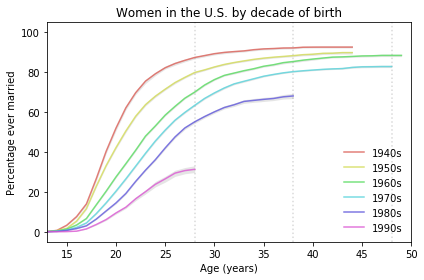

In [32]:
palette = set_palette('hls', 6)
ages = [28, 38, 48]
draw_age_lines(ages)
options_w = dict(title='Women in the U.S. by decade of birth')
PlotSurvivalFunctions('figs/marriage4', sf_map, None, **options_w)

In [33]:
import shelve

with shelve.open('predictions') as d:
    sf_map_pred = d['sf_map_pred']

Writing figs/marriage4.pdf
Writing figs/marriage4.png


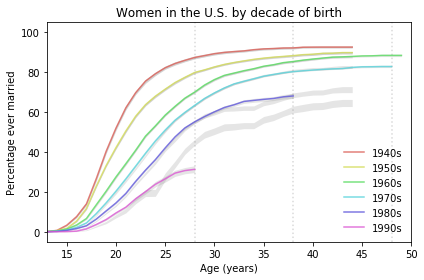

In [34]:
options_w = dict(title='Women in the U.S. by decade of birth')

marriage.PlotSurvivalFunctions(sf_map_pred, predict_flag=True)

palette = set_palette('hls', 6)
draw_age_lines(ages)
options_w = dict(title='Women in the U.S. by decade of birth')
PlotSurvivalFunctions('figs/marriage4', sf_map, None, **options_w)

Make a table of marriage rates for each cohort at each age:

In [35]:
def MakeTable(sf_map, ages):
    t = []
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        t.append((name, vals))
    return t

In [36]:
def MakePercentageTable(sf_map, ages):
    """Prints percentage unmarried for each cohort at each age.
    """
    t = MakeTable(sf_map, ages)
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        print(name, '&', ' & '.join('%0.0f' % (val*100) for val in vals), r'\\')
        
MakePercentageTable(sf_map, ages)

40 & 8742 & 9220 & nan \\
50 & 7989 & 8834 & nan \\
60 & 7008 & 8538 & 8845 \\
70 & 6343 & 8032 & 8286 \\
80 & 5516 & 6812 & nan \\
90 & 3134 & nan & nan \\


Generate projections:

In [37]:
%time sf_map_pred = marriage.EstimateSurvivalByCohort(resps, iters=iters, cutoffs=cutoffs, predict_flag=True)
del sf_map_pred[30]
del sf_map_pred[100]

CPU times: user 15.3 s, sys: 140 ms, total: 15.5 s
Wall time: 15.5 s


In [38]:
import shelve

if SAVE_PRED:
    with shelve.open('predictions') as d:
        d['sf_map_pred'] = sf_map_pred

In [39]:
for cohort, seq in sf_map_pred.items():
    if cohort > 90:
        break
    medians = [sf.MakeCdf().Value(0.5) for sf in seq]
    print(cohort, np.median(medians))

40 20.0
50 21.0
60 24.0
70 25.0
80 27.0
90 37.0


And make the figure showing projections:

Writing figs/marriage5.pdf
Writing figs/marriage5.png


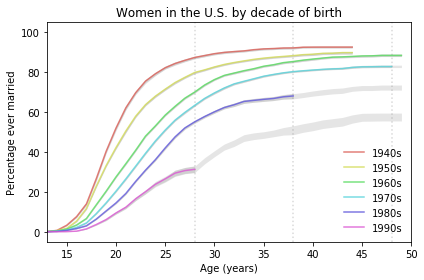

In [40]:
palette = set_palette('hls', 6)
draw_age_lines(ages)
PlotSurvivalFunctions('figs/marriage5', sf_map, sf_map_pred, **options_w)

Make the table again with the projections filled in.

In [41]:
MakePercentageTable(sf_map_pred, ages)

40 & 8746 & 9225 & nan \\
50 & 7983 & 8819 & nan \\
60 & 7001 & 8530 & 8848 \\
70 & 6339 & 8031 & 8299 \\
80 & 5516 & 6813 & 7228 \\
90 & 3116 & 5113 & 5744 \\


In [42]:
def PlotFractions(sf_map, ages, label_flag=False, **options):
    t = MakeTable(sf_map, ages)
    cohorts, cols = zip(*t)
    rows = zip(*cols)

    thinkplot.PrePlot(3)
    t = list(zip(ages, rows))
    for age, row in reversed(t):
        label = 'at age %d' % age if label_flag else ''
        thinkplot.Plot(cohorts, row, label=label, **options)

Writing figs/marriage6.pdf


/home/downey/MarriageNSFG/thinkplot.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(rows, cols, 1)


Writing figs/marriage6.png


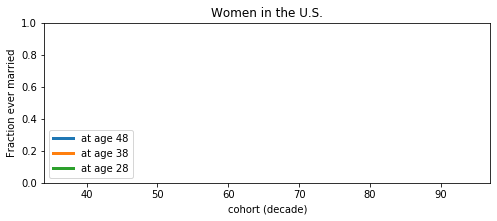

In [43]:
PlotFractions(sf_map_pred, ages, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(sf_map, ages, label_flag=True, alpha=1)

#fontsize=12
#thinkplot.Text(36, 0.26, '24', fontsize=fontsize)
#thinkplot.Text(37, 0.13, '9', fontsize=fontsize)
#thinkplot.Text(37, 0.07, '7', fontsize=fontsize)

#thinkplot.Text(90, 0.85, '80', fontsize=fontsize)
#thinkplot.Text(90, 0.56, '51', fontsize=fontsize)
#thinkplot.Text(89.5, 0.47, '42', fontsize=fontsize)

#thinkplot.Text(80, 0.42, '35', fontsize=fontsize)
#thinkplot.Text(70, 0.18, '18', fontsize=fontsize)

thinkplot.Config(xlim=[34, 97], ylim=[0, 1], legend=True, loc='lower left',
                 xlabel='cohort (decade)', ylabel='Fraction ever married', 
                 title='Women in the U.S.')

thinkplot.Save(root='figs/marriage6', **options)

## Marriage patterns for men

In [44]:
%time df2 = pd.read_hdf('MaleMarriageData.hdf', 'MaleMarriageData')
df2.shape

CPU times: user 38.5 ms, sys: 7.97 ms, total: 46.4 ms
Wall time: 45 ms


(34398, 38)

In [45]:
for cycle, group in df2.groupby('cycle'):
    SummarizeCycle(cycle, group)

6  &  2002--2003 & 4928 & 1957--1988 \\
7  &  2006--2010 & 10403 & 1961--1995 \\
8  &  2011--2013 & 4815 & 1966--1998 \\
9  &  2013--2015 & 4506 & 1968--2000 \\
10  &  2015--2017 & 4540 & 1965--2002 \\
11  &  2017--2019 & 5206 & 1968--2004 \\


In [46]:
sum(df2.missing)

0

In [47]:
marriage.DigitizeResp(df2)
grouped = df2.groupby('birth_index')
for name, group in iter(grouped):
    age_range = '%d--%d' % (int(group.age.min()), int(group.age_index.max()))
    print(name, '&', len(group), '&', age_range,
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

50 & 322 & 42--45 & 224 & 0 \\
60 & 4071 & 32--50 & 2827 & 0 \\
70 & 9476 & 22--49 & 5743 & 0 \\
80 & 11421 & 15--39 & 3259 & 0 \\
90 & 7856 & 15--29 & 457 & 0 \\
100 & 1252 & 15--19 & 1 & 0 \\


In [48]:
cutoffs2 = ComputeCutoffs(df2)
cutoffs2

{50: 45, 60: 50, 70: 49, 80: 39, 90: 29, 100: 19}

In [49]:
resps2 = [group for cycle, group in df2.groupby('cycle')]

In [50]:
%time sf_map_male = marriage.EstimateSurvivalByCohort(resps2, iters=iters, cutoffs=cutoffs2)
del sf_map_male[100]

CPU times: user 8.25 s, sys: 15.8 ms, total: 8.27 s
Wall time: 8.28 s


Writing figs/marriage7.pdf
Writing figs/marriage7.png


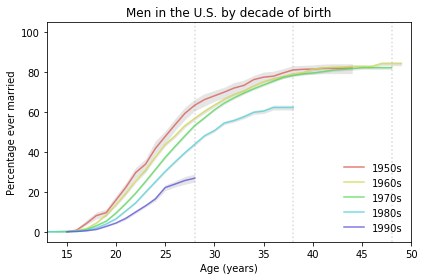

In [51]:
palette = set_palette('hls', 6)
draw_age_lines(ages)
options_m = dict(title='Men in the U.S. by decade of birth')
PlotSurvivalFunctions('figs/marriage7', sf_map_male, None, **options_m)

In [52]:
%time sf_map_male_pred = marriage.EstimateSurvivalByCohort(resps2, iters=iters, cutoffs=cutoffs2, predict_flag=True)
del sf_map_male_pred[100]

CPU times: user 9.86 s, sys: 7.68 ms, total: 9.87 s
Wall time: 9.98 s


In [53]:
for cohort, seq in sf_map_male_pred.items():
    if cohort > 90:
        break
    medians = [sf.MakeCdf().Value(0.5) for sf in seq]
    print(cohort, np.median(medians))

50 26.0
60 27.0
70 28.0
80 30.0
90 36.0


Writing figs/marriage8.pdf
Writing figs/marriage8.png


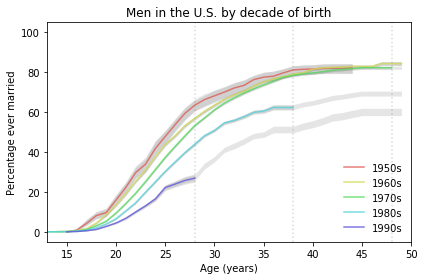

In [54]:
palette = set_palette('hls', 6)
draw_age_lines(ages)
PlotSurvivalFunctions('figs/marriage8', sf_map_male, sf_map_male_pred, **options_m)

In [55]:
MakePercentageTable(sf_map_male, ages)

50 & 6349 & 8117 & nan \\
60 & 5686 & 7911 & 8433 \\
70 & 5331 & 7840 & 8230 \\
80 & 4393 & 6233 & nan \\
90 & 2690 & nan & nan \\


In [56]:
MakePercentageTable(sf_map_male_pred, ages)

50 & 6387 & 8089 & nan \\
60 & 5701 & 7919 & 8444 \\
70 & 5323 & 7833 & 8229 \\
80 & 4395 & 6247 & 6921 \\
90 & 2725 & 5117 & 6009 \\


Writing figs/marriage9.pdf


/home/downey/MarriageNSFG/thinkplot.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(rows, cols, 1)


Writing figs/marriage9.png


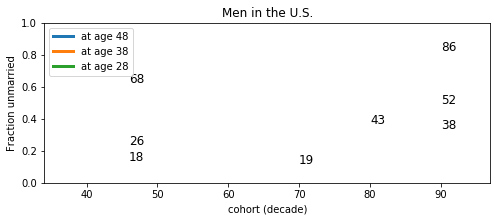

In [57]:
PlotFractions(sf_map_male_pred, ages, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(sf_map_male, ages, label_flag=True, alpha=1)

fontsize=12
thinkplot.Text(46, 0.69, '68', fontsize=fontsize)
thinkplot.Text(46, 0.30, '26', fontsize=fontsize)
thinkplot.Text(46, 0.20, '18', fontsize=fontsize)

thinkplot.Text(70, 0.18, '19', fontsize=fontsize)

thinkplot.Text(80, 0.43, '43', fontsize=fontsize)

thinkplot.Text(90, 0.89, '86', fontsize=fontsize)
thinkplot.Text(90, 0.56, '52', fontsize=fontsize)
thinkplot.Text(90, 0.40, '38', fontsize=fontsize)

thinkplot.Config(xlim=[34, 97], ylim=[0, 1], legend=True, loc='upper left',
                 xlabel='cohort (decade)', ylabel='Fraction unmarried', 
                 title='Men in the U.S.')

thinkplot.Save(root='figs/marriage9', **options)